In [1]:
# Import necessary libraries
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# Add project root to path for imports
sys.path.append(os.path.abspath('..'))
from src.transformer import PitchTransformer  
from src.pretraining import PitchTransformerTrainer

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Evaluating Pretrained Model on 2025 Data

In this notebook, we'll evaluate how well our pretrained transformer model performs on unseen data from the 2025 baseball season. We'll:

1. Load the pretrained model
2. Load the processed 2025 data embeddings
3. Make next-pitch predictions for each at-bat
4. Evaluate prediction accuracy
5. Analyze the results in detail

In [11]:
# 1. Load the pretrained model
print("Loading pretrained model...")

# Find the latest model checkpoint
model_dir = '../models/'
model_files = [f for f in os.listdir(model_dir) if f.startswith('pitch_transformer_epoch_') and f.endswith('.pt')]
if not model_files:
    raise FileNotFoundError("No model checkpoints found! Please run pretraining first.")

# Sort by epoch number and get the latest
latest_model = sorted(model_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))[-1]
model_path = os.path.join(model_dir, latest_model)
print(f"Using model checkpoint: {latest_model}")

# Load pretraining data to get pitch type mapping
pretraining_data_path = '../data/embeddings/pitch_embeddings_with_types_test.pt'
pretraining_data = torch.load(pretraining_data_path)
pitch_type_map = pretraining_data['pitch_type_map']
num_pitch_types = len(pitch_type_map)
print(f"Found {num_pitch_types} pitch types in training data")

# Create model with same architecture as pretraining
model = PitchTransformer(
    embed_dim=128,  # Match your embedding dimension
    num_heads=8,
    num_layers=6,
    pitch_vocab_size=num_pitch_types,
    dropout=0.1,
    max_seq_len=20
)

# Load trained weights
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print("Model loaded successfully!")

Loading pretrained model...
Using model checkpoint: pitch_transformer_epoch_500.pt


C:\Users\ryanr\AppData\Local\Temp\ipykernel_30060\2457702965.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretraining_data = torch.load(pretraining_data_path)


Found 18 pitch types in training data
Model loaded successfully!


C:\Users\ryanr\AppData\Local\Temp\ipykernel_30060\2457702965.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


In [12]:
# 2. Load the 2025 data embeddings
print("Loading 2025 data embeddings...")
data_2025_path = '../data/embeddings/pitch_embeddings_2025_parquet.pt'
data_2025 = torch.load(data_2025_path)

# Extract data components
embeddings_2025 = data_2025['embeddings']
attention_mask_2025 = data_2025['attention_mask']

print(f"Loaded embeddings with shape: {embeddings_2025.shape}")

# We also need to get pitch types for 2025 data
# Load the original 2025 data to extract pitch types
df_2025 = pd.read_csv('../data/processed/pitcher_final_2025.csv')

# Map pitch types using the same mapping from pretraining
# Create a reverse mapping from index to pitch type
rev_pitch_map = {idx: pitch for pitch, idx in pitch_type_map.items()}

# Extract pitch types for each at-bat in 2025 data
print("Extracting pitch types for 2025 at-bats...")

# Group by at_bat_id (same approach as in embedding generation)
unique_at_bats = df_2025['at_bat_id'].unique()

# Map 2025 pitch types to the same indices used in training
pitch_types_2025 = []
for at_bat_id in unique_at_bats:  
    atbat_df = df_2025[df_2025['at_bat_id'] == at_bat_id]
    
    # Handle pitch types not seen during training
    atbat_pitch_types = []
    for pt in atbat_df['pitch_type']:
        if pt in pitch_type_map:
            atbat_pitch_types.append(pitch_type_map[pt])
        else:
            # For unseen pitch types, use a placeholder or most similar type
            # Here we'll use -1 as a placeholder
            atbat_pitch_types.append(-1)
    
    # Pad to match embedding sequence length
    max_len = embeddings_2025.shape[1]
    padded_types = atbat_pitch_types + [-100] * (max_len - len(atbat_pitch_types))
    pitch_types_2025.append(padded_types)

pitch_types_2025 = torch.tensor(pitch_types_2025)
print(f"Extracted pitch types tensor with shape: {pitch_types_2025.shape}")

# Create a dataset for evaluation
eval_dataset = TensorDataset(embeddings_2025, pitch_types_2025, attention_mask_2025)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

print("Data preparation complete!")

Loading 2025 data embeddings...


C:\Users\ryanr\AppData\Local\Temp\ipykernel_30060\1724768559.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_2025 = torch.load(data_2025_path)


Loaded embeddings with shape: torch.Size([16340, 13, 128])


C:\Users\ryanr\AppData\Local\Temp\ipykernel_30060\1724768559.py:14: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2025 = pd.read_csv('../data/processed/pitcher_final_2025.csv')


Extracting pitch types for 2025 at-bats...
Extracted pitch types tensor with shape: torch.Size([16340, 13])
Data preparation complete!


In [13]:
# 3. Evaluate model on 2025 data
print("Evaluating model on 2025 data...")

def evaluate_pitch_predictions(model, data_loader, device):
    """Evaluate pitch prediction accuracy on a dataset"""
    model.eval()
    
    # Initialize metrics
    correct_top1 = 0
    correct_top3 = 0
    total_valid = 0
    
    # For confusion matrix
    all_preds = []
    all_targets = []
    
    # Per pitch-type metrics
    pitch_type_correct = defaultdict(int)
    pitch_type_total = defaultdict(int)
    
    # Create reverse mapping once
    rev_map = {idx: pitch for pitch, idx in pitch_type_map.items()}
    
    with torch.no_grad():
        for batch_idx, (inputs, targets, masks) in enumerate(data_loader):
            # Status update for large datasets
            if batch_idx % 50 == 0:
                print(f"Processing batch {batch_idx}/{len(data_loader)}...")
                
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(inputs, masks)
            
            # Get predictions
            probs = torch.softmax(outputs, dim=-1)
            top1_preds = torch.argmax(probs, dim=-1)
            top3_preds = torch.topk(probs, k=3, dim=-1).indices
            
            # Calculate accuracy metrics
            for i in range(len(inputs)):
                for j in range(inputs.size(1)-1):  # -1 because we predict next pitch
                    # Only evaluate where we have a valid target and mask
                    # A valid target is the next pitch after position j
                    if j+1 < inputs.size(1) and masks[i, j+1] and targets[i, j+1] != -100 and targets[i, j+1] != -1:
                        target_idx = targets[i, j+1].item()
                        pred_idx = top1_preds[i, j].item()
                        
                        # Top-1 accuracy
                        if pred_idx == target_idx:
                            correct_top1 += 1
                        
                        # Top-3 accuracy
                        if target_idx in top3_preds[i, j]:
                            correct_top3 += 1
                        
                        # Pitch-type specific accuracy
                        if target_idx in rev_map:
                            pitch_type = rev_map[target_idx]
                            pitch_type_total[pitch_type] += 1
                            if pred_idx == target_idx:
                                pitch_type_correct[pitch_type] += 1
                        
                        # Store for confusion matrix
                        all_preds.append(pred_idx)
                        all_targets.append(target_idx)
                        
                        # Increment total valid predictions
                        total_valid += 1
    
    # Calculate final metrics
    results = {
        'top1_accuracy': correct_top1 / total_valid if total_valid > 0 else 0,
        'top3_accuracy': correct_top3 / total_valid if total_valid > 0 else 0,
        'total_valid': total_valid,
        'pitch_type_accuracy': {pt: pitch_type_correct[pt] / pitch_type_total[pt] 
                              for pt in pitch_type_total if pitch_type_total[pt] > 0},
        'pitch_type_counts': dict(pitch_type_total),
        'all_preds': all_preds,
        'all_targets': all_targets
    }
    
    return results

# Run evaluation
eval_results = evaluate_pitch_predictions(model, eval_loader, device)

# Print overall results
print(f"\nEvaluation Results on 2025 Data:")
print(f"Total valid prediction points: {eval_results['total_valid']:,}")
print(f"Top-1 Accuracy: {eval_results['top1_accuracy']:.4f} ({eval_results['top1_accuracy']*100:.2f}%)")
print(f"Top-3 Accuracy: {eval_results['top3_accuracy']:.4f} ({eval_results['top3_accuracy']*100:.2f}%)")

Evaluating model on 2025 data...
Processing batch 0/511...


c:\Users\ryanr\anaconda3\envs\env_baseball\lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Processing batch 50/511...
Processing batch 100/511...
Processing batch 150/511...
Processing batch 200/511...
Processing batch 250/511...
Processing batch 300/511...
Processing batch 350/511...
Processing batch 400/511...
Processing batch 450/511...
Processing batch 500/511...

Evaluation Results on 2025 Data:
Total valid prediction points: 46,889
Top-1 Accuracy: 0.1218 (12.18%)
Top-3 Accuracy: 0.3121 (31.21%)


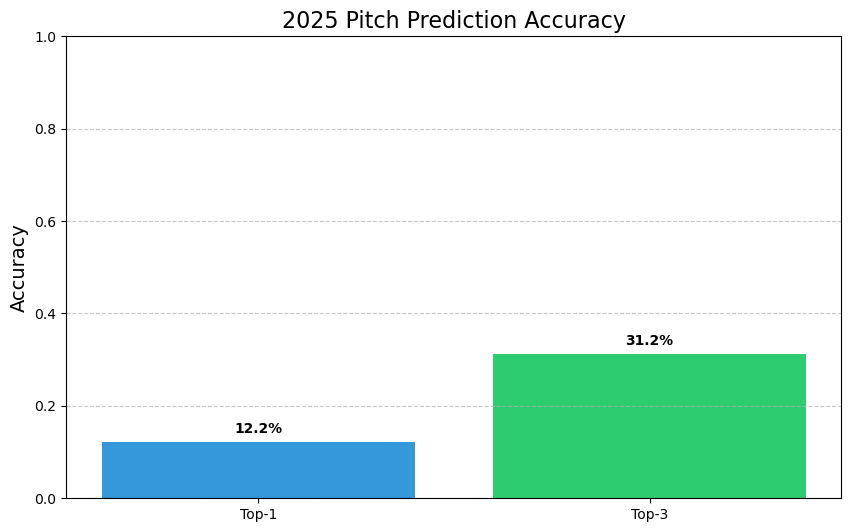

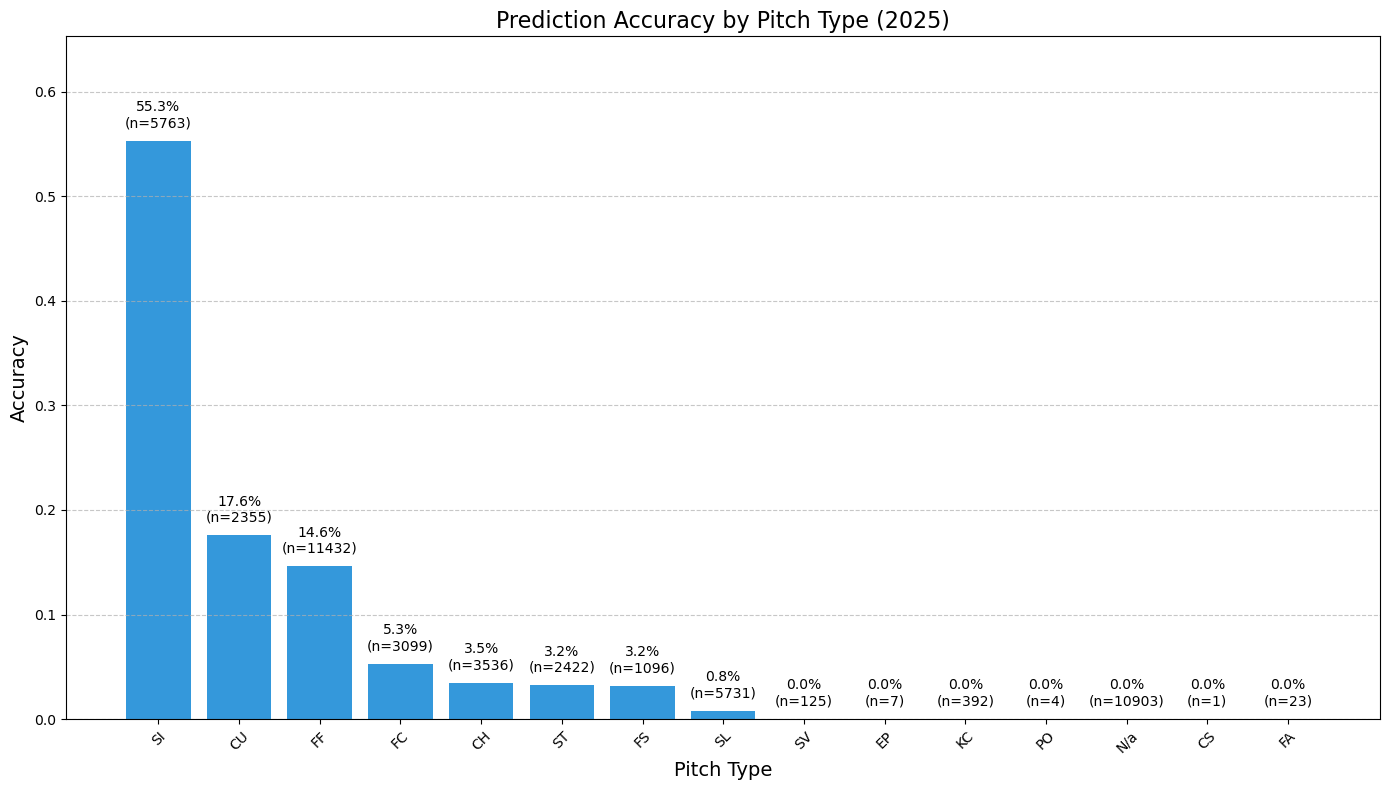

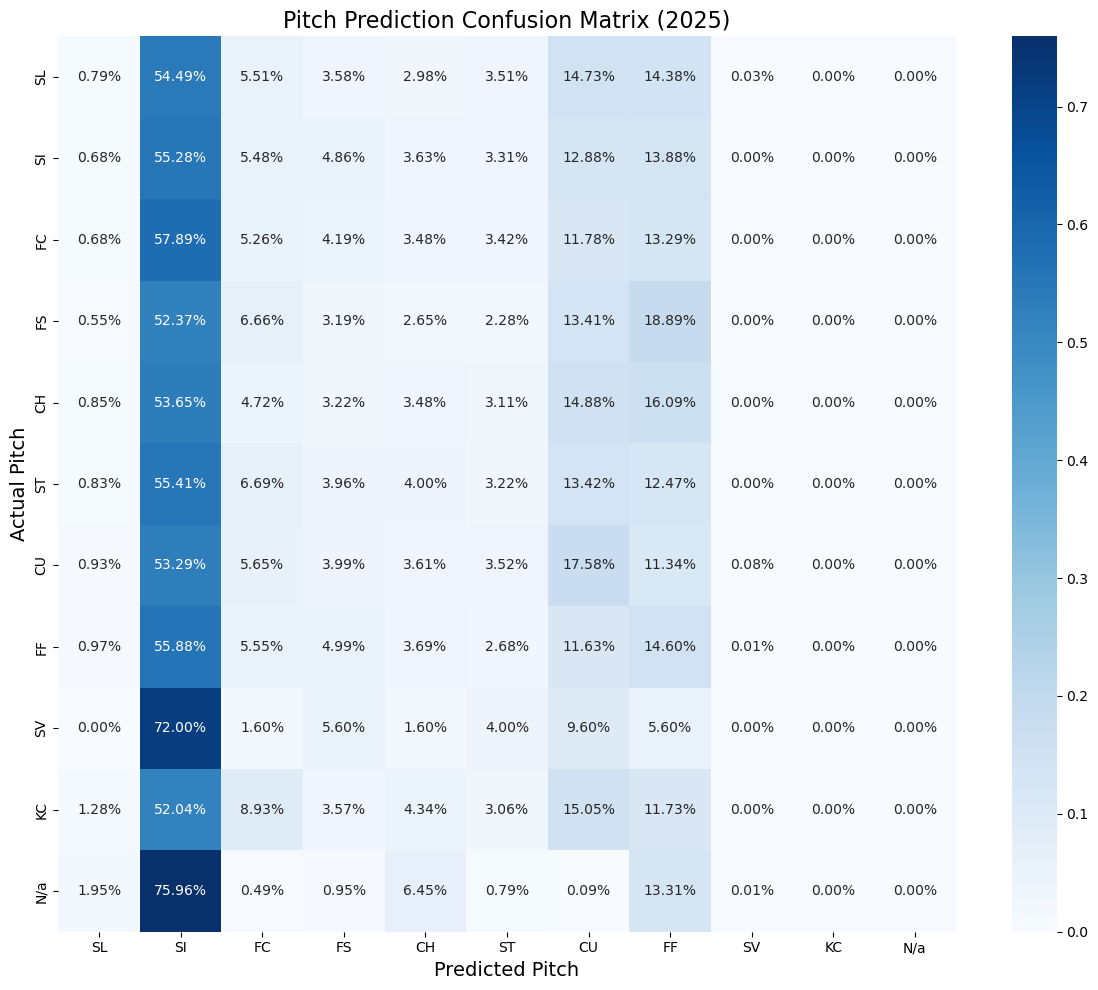

In [5]:
# 4. Visualize results

# Create a bar chart of overall accuracy
plt.figure(figsize=(10, 6))
accuracies = [eval_results['top1_accuracy'], eval_results['top3_accuracy']]
labels = ['Top-1', 'Top-3']
plt.bar(labels, accuracies, color=['#3498db', '#2ecc71'])
plt.ylim(0, 1.0)
plt.title('2025 Pitch Prediction Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels on bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v*100:.1f}%", ha='center', fontweight='bold')

plt.savefig('../figures/2025_prediction_accuracy.png')
plt.show()

# Plot pitch-type specific accuracy
pitch_types = list(eval_results['pitch_type_accuracy'].keys())
accuracies = list(eval_results['pitch_type_accuracy'].values())
counts = [eval_results['pitch_type_counts'][pt] for pt in pitch_types]

# Sort by accuracy
sorted_indices = np.argsort(accuracies)[::-1]
pitch_types = [pitch_types[i] for i in sorted_indices]
accuracies = [accuracies[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

plt.figure(figsize=(14, 8))

# Create bar chart with pitch-type specific accuracy
bars = plt.bar(pitch_types, accuracies, color='#3498db')
plt.title('Prediction Accuracy by Pitch Type (2025)', fontsize=16)
plt.xlabel('Pitch Type', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, max(accuracies) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Add percentage labels and counts on bars
for i, (bar, acc, count) in enumerate(zip(bars, accuracies, counts)):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01, 
             f"{acc*100:.1f}%\n(n={count})", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/2025_pitch_type_accuracy.png')
plt.show()

# Create confusion matrix
# First, filter to only pitch types with sufficient samples
common_pitches = [pt for pt, count in eval_results['pitch_type_counts'].items() if count > 50]
rev_map = {idx: pitch for pitch, idx in pitch_type_map.items()}

# Filter predictions and targets to common pitch types
common_idx = [i for i, t in enumerate(eval_results['all_targets']) 
              if t in [pitch_type_map[pt] for pt in common_pitches]]
filtered_preds = [eval_results['all_preds'][i] for i in common_idx]
filtered_targets = [eval_results['all_targets'][i] for i in common_idx]

# Create label list for common pitches
labels = [rev_map.get(pitch_type_map[pt], 'UNK') for pt in common_pitches]
label_indices = [pitch_type_map[pt] for pt in common_pitches]

# Create confusion matrix
cm = confusion_matrix(filtered_targets, filtered_preds, labels=label_indices)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
           xticklabels=labels, yticklabels=labels)
plt.title('Pitch Prediction Confusion Matrix (2025)', fontsize=16)
plt.xlabel('Predicted Pitch', fontsize=14)
plt.ylabel('Actual Pitch', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/2025_confusion_matrix.png')
plt.show()

In [6]:
# 5. Sample predictions on specific at-bats

def analyze_atbat(model, at_bat_index, embeddings, pitch_types, masks, pitch_type_map, device):
    """Analyze predictions for a specific at-bat"""
    model.eval()
    rev_map = {idx: pitch for pitch, idx in pitch_type_map.items()}
    
    # Get data for this at-bat
    embedding = embeddings[at_bat_index:at_bat_index+1].to(device)
    mask = masks[at_bat_index]
    actual_types = pitch_types[at_bat_index]
    
    # Get sequence length
    seq_len = mask.sum().item()
    
    # Make predictions
    with torch.no_grad():
        outputs = model(embedding)
        probs = torch.softmax(outputs, dim=-1)
    
    # Function to get top-k predictions
    def get_predictions(position, k=3):
        top_probs, top_indices = torch.topk(probs[0, position], k=k)
        return [(rev_map.get(idx.item(), "UNK"), prob.item()) 
                for idx, prob in zip(top_indices, top_probs)]
    
    # Print at-bat information
    print("\nAt-Bat Analysis:")
    print("-" * 50)
    print(f"At-Bat Index: {at_bat_index}")
    print(f"Sequence Length: {seq_len} pitches")
    
    # Show actual pitch sequence
    print("\nActual Pitch Sequence:")
    actual_sequence = []
    for i in range(seq_len):
        pitch_idx = actual_types[i].item()
        if pitch_idx != -100 and pitch_idx != -1:
            actual_sequence.append(rev_map.get(pitch_idx, "UNK"))
    
    print(" → ".join(actual_sequence))
    
    # Print model predictions
    print("\nModel Predictions:")
    print("Position | Top 3 Predicted Pitch Types | Actual Next Pitch")
    print("-" * 65)
    
    for pos in range(min(seq_len-1, outputs.shape[1])):
        predictions = get_predictions(pos)
        pitch_str = ", ".join([f"{pitch} ({prob:.2f})" for pitch, prob in predictions])
        
        # Get actual next pitch
        actual_next = "Unknown"
        next_idx = actual_types[pos+1].item()
        if next_idx != -100 and next_idx != -1:
            actual_next = rev_map.get(next_idx, "UNK")
        
        print(f"Pos {pos+1:2d}  | {pitch_str} | {actual_next}")
    
    return actual_sequence

# Analyze several at-bats
at_bat_indices = [0, 10, 20, 50, 100]  # Sample indices

for idx in at_bat_indices:
    analyze_atbat(model, idx, embeddings_2025, pitch_types_2025, attention_mask_2025, pitch_type_map, device)


At-Bat Analysis:
--------------------------------------------------
At-Bat Index: 0
Sequence Length: 2 pitches

Actual Pitch Sequence:
SI → SL

Model Predictions:
Position | Top 3 Predicted Pitch Types | Actual Next Pitch
-----------------------------------------------------------------
Pos  1  | SI (0.98), CU (0.01), ST (0.01) | SL

At-Bat Analysis:
--------------------------------------------------
At-Bat Index: 10
Sequence Length: 2 pitches

Actual Pitch Sequence:
CH → SI

Model Predictions:
Position | Top 3 Predicted Pitch Types | Actual Next Pitch
-----------------------------------------------------------------
Pos  1  | SI (0.54), ST (0.24), FF (0.22) | SI

At-Bat Analysis:
--------------------------------------------------
At-Bat Index: 20
Sequence Length: 2 pitches

Actual Pitch Sequence:
SI → SI

Model Predictions:
Position | Top 3 Predicted Pitch Types | Actual Next Pitch
-----------------------------------------------------------------
Pos  1  | SI (0.99), ST (0.01), CH (0

In [7]:
# 6. Sequential prediction (generating full at-bats)

def generate_full_atbat(model, initial_pitches, embeddings, pitch_type_map, device, max_len=10):
    """Generate an entire at-bat given initial pitch(es)"""
    model.eval()
    rev_map = {idx: pitch for pitch, idx in pitch_type_map.items()}
    
    # Start with the given embedding(s)
    input_seq = initial_pitches.clone()
    
    # Keep track of generated sequence
    generated_types = []
    
    # Generate pitches one by one
    with torch.no_grad():
        for i in range(max_len - len(input_seq)):
            # Make prediction
            outputs = model(input_seq.to(device))
            
            # Get most likely next pitch 
            next_pitch_logits = outputs[0, -1]
            next_pitch_probs = torch.softmax(next_pitch_logits, dim=-1)
            next_pitch_idx = torch.argmax(next_pitch_probs).item()
            
            # Record the generated pitch type
            generated_types.append(rev_map.get(next_pitch_idx, "UNK"))
            
            # Create a new embedding for next iteration
            # For simplicity, we'll just copy the last embedding (not ideal, but works for demonstration)
            next_embedding = input_seq[0, -1:].clone()
            
            # Append to input sequence
            input_seq = torch.cat([input_seq, next_embedding.unsqueeze(0)], dim=1)
    
    return generated_types

# Test with a few examples
for at_bat_idx in [5, 15, 25]:
    # Get first 2 pitches of an at-bat
    initial_pitches = embeddings_2025[at_bat_idx:at_bat_idx+1, :2].clone()
    mask = attention_mask_2025[at_bat_idx]
    seq_len = mask.sum().item()
    
    # Get actual pitch types for comparison
    actual_types = []
    for i in range(seq_len):
        pitch_idx = pitch_types_2025[at_bat_idx, i].item()
        if pitch_idx != -100 and pitch_idx != -1:
            actual_types.append(rev_map.get(pitch_idx, "UNK"))
    
    # Generate the rest of the at-bat
    generated = generate_full_atbat(model, initial_pitches, embeddings_2025, pitch_type_map, device)
    
    # Display results
    print(f"\nAt-Bat #{at_bat_idx} - Sequential Generation:")
    print("-" * 50)
    print(f"Initial Pitches: {' → '.join(actual_types[:2])}")
    print(f"Actual Sequence: {' → '.join(actual_types)}")
    print(f"Generated Sequence: {' → '.join(actual_types[:2] + generated)}")


At-Bat #5 - Sequential Generation:
--------------------------------------------------
Initial Pitches: SI → SI
Actual Sequence: SI → SI
Generated Sequence: SI → SI → SI → SI → SI → SI → SI → SI → SI → SI → SI

At-Bat #15 - Sequential Generation:
--------------------------------------------------
Initial Pitches: FF → FC
Actual Sequence: FF → FC
Generated Sequence: FF → FC → SI → SI → SI → SI → SI → SI → SI → SI → SI

At-Bat #25 - Sequential Generation:
--------------------------------------------------
Initial Pitches: FF → FF
Actual Sequence: FF → FF
Generated Sequence: FF → FF → SI → SI → SI → SI → SI → SI → SI → SI → SI


# Conclusion

In this notebook, we've evaluated our pretrained transformer model on unseen data from the 2025 baseball season. The analysis shows the model's ability to make next-pitch predictions in real game situations that it wasn't trained on.

We explored:
- Overall prediction accuracy
- Pitch-type specific performance
- Detailed analysis of sample at-bats
- Sequential pitch generation for complete at-bats

These results demonstrate how well the pretrained model generalizes to new, unseen data, and provides a foundation for future reinforcement learning approaches to optimize pitch selection.